In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.layers import Dense, Flatten,Dropout,GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import confusion_matrix, classification_report
import cv2
import pickle
from sklearn.model_selection import train_test_split

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Load the dataset
training_file = r"/content/drive/MyDrive/traffic_sign_dataset/train.p"
testing_file = r"/content/drive/MyDrive/traffic_sign_dataset/test.p"

def load_traffic_sign_data(training_file, testing_file):
    with open(training_file, mode='rb') as f:
        train = pickle.load(f)
    with open(testing_file, mode='rb') as f:
        test = pickle.load(f)
    return train, test

train, test = load_traffic_sign_data(training_file, testing_file)
X_train, y_train = train['features'], train['labels']
X_test, y_test = test['features'], test['labels']




In [ ]:
# preprocessing features
def preprocess_features(X):
    X_yuv = np.array([cv2.cvtColor(img, cv2.COLOR_RGB2YUV)[:, :, 0] for img in X])
    X_yuv = np.array([cv2.equalizeHist(np.uint8(img)) for img in X_yuv])
    X_yuv = np.expand_dims(X_yuv, axis=-1)  # Keep single-channel shape
    X_yuv = X_yuv.astype(np.float32)
    X_yuv -= np.mean(X_yuv, axis=0)
    X_yuv /= (np.std(X_yuv, axis=0) + np.finfo('float32').eps)
    return X_yuv

X_train_norm= preprocess_features(X_train)
X_test_norm= preprocess_features(X_test)

In [ ]:
#train-test split
test_size=0.2
X_train_norm, X_val_norm, y_train, y_val = train_test_split(X_train_norm, y_train, test_size=test_size, random_state=42)

# convert graysclae to 3-channel format
X_train_norm = np.repeat(X_train_norm,3,axis=-1)
X_val_norm = np.repeat(X_val_norm, 3,axis=-1)
X_test_norm = np.repeat(X_test_norm, 3,axis=-1)

In [ ]:
# data augmentation
image_datagen = ImageDataGenerator(
    rotation_range=20,  # Reduce excessive rotation
    zoom_range=0.1,  # Avoid too much zoom
    shear_range=0.1,
    brightness_range=[0.9, 1.1],  # Keep close to original brightness
    width_shift_range=0.1,
    height_shift_range=0.1
)

# DenseNet121 Model(with transfer learning)
def create_densenet_model(input_shape,n_classes):
  base_model=DenseNet121(weights='imagenet',include_top=False,input_shape=input_shape)
  base_model.trainable=True #fine tuning it

  x= GlobalAveragePooling2D()(base_model.output)
  x = Dense(512, activation='relu')(x)
  x=Dropout(0.5)(x)
  x=Dense(256,activation='relu')(x)
  x=Dropout(0.5)(x)
  outputs= Dense(n_classes,activation='softmax')(x)

  model=Model(inputs=base_model.input,outputs=outputs)
  return model

input_shape=(32,32,3)
n_classes=43
model=create_densenet_model(input_shape,n_classes)

# Compile Model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])



In [ ]:
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

BATCHSIZE=64
EPOCHS=50

# ✅ Train Model
history = model.fit(
    image_datagen.flow(X_train_norm, y_train, batch_size=BATCHSIZE),
    validation_data=(X_val_norm, y_val),
    epochs=EPOCHS,
    callbacks=[early_stopping]
)
# saving the weighs
model.save_weights('densenet_traffic_sign.weights.h5')
print("model training is complete. Weights saved sucessfully")

Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


435/435 ━━━━━━━━━━━━━━━━━━━━ 413s 801ms/step - accuracy: 0.0245 - loss: 4.8945 - val_accuracy: 0.0825 - val_loss: 3.6561
Epoch 2/50
435/435 ━━━━━━━━━━━━━━━━━━━━ 382s 800ms/step - accuracy: 0.0549 - loss: 3.8891 - val_accuracy: 0.1602 - val_loss: 3.3691
Epoch 3/50
435/435 ━━━━━━━━━━━━━━━━━━━━ 342s 787ms/step - accuracy: 0.0918 - loss: 3.5862 - val_accuracy: 0.2103 - val_loss: 3.1047
Epoch 4/50
435/435 ━━━━━━━━━━━━━━━━━━━━ 335s 771ms/step - accuracy: 0.1349 - loss: 3.3586 - val_accuracy: 0.2705 - val_loss: 2.8543
Epoch 5/50
435/435 ━━━━━━━━━━━━━━━━━━━━ 342s 787ms/step - accuracy: 0.1793 - loss: 3.1198 - val_accuracy: 0.3197 - val_loss: 2.6277
Epoch 6/50
435/435 ━━━━━━━━━━━━━━━━━━━━ 385s 793ms/step - accuracy: 0.2292 - loss: 2.8957 - val_accuracy: 0.3603 - val_loss: 2.3821
Epoch 7/50
435/435 ━━━━━━━━━━━━━━━━━━━━ 346s 796ms/step - accuracy: 0.2736 - loss: 2.6740 - val_accuracy: 0.4062 - val_loss: 2.1576
Epoch 8/50
435/435 ━━━━━━━━━━━━━━━━━━━━ 351s 807ms/step - accuracy: 0.3173 - loss: 2.47

In [ ]:
test_loss, test_accuracy = model.evaluate(X_test_norm, y_test)
print(f"Test Accuracy: {test_accuracy:.4f}, Test Loss: {test_loss:.4f}")


395/395 ━━━━━━━━━━━━━━━━━━━━ 35s 87ms/step - accuracy: 0.8822 - loss: 0.4792
Test Accuracy: 0.8829, Test Loss: 0.4845


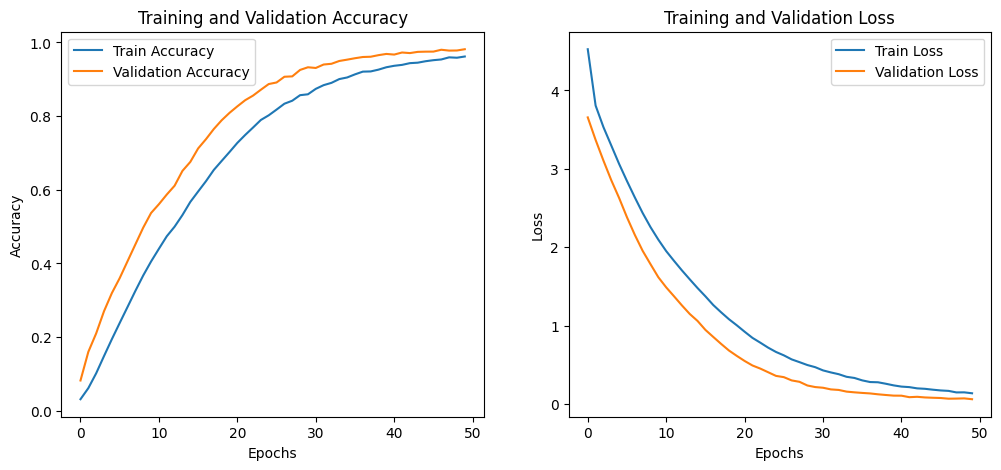

In [ ]:
def plot_accuracy_loss(history):
    plt.figure(figsize=(12, 5))

    # Accuracy plot
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.title('Training and Validation Accuracy')

    # Loss plot
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Training and Validation Loss')

    plt.show()

  # Generate accuracy & loss graph
plot_accuracy_loss(history)

395/395 ━━━━━━━━━━━━━━━━━━━━ 32s 82ms/step


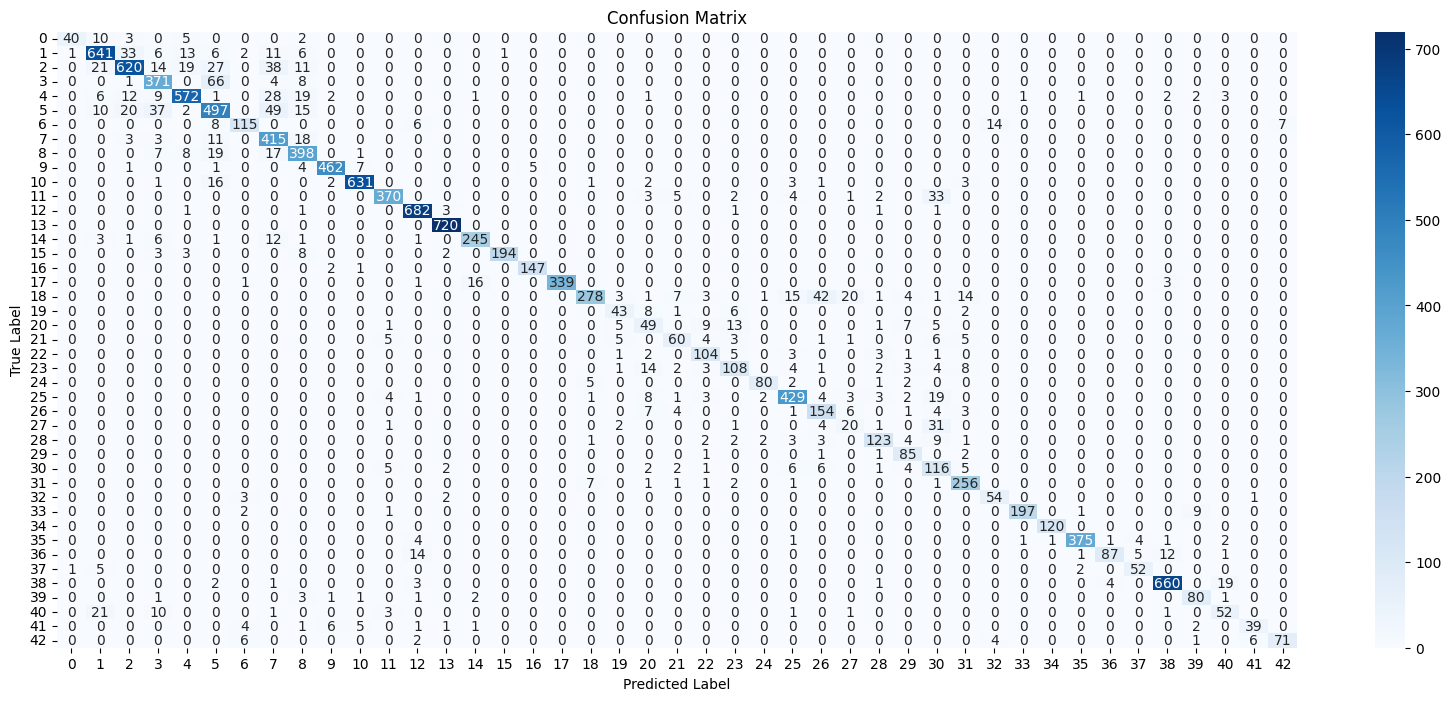

Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.67      0.78        60
           1       0.89      0.89      0.89       720
           2       0.89      0.83      0.86       750
           3       0.79      0.82      0.81       450
           4       0.92      0.87      0.89       660
           5       0.76      0.79      0.77       630
           6       0.86      0.77      0.81       150
           7       0.72      0.92      0.81       450
           8       0.80      0.88      0.84       450
           9       0.97      0.96      0.97       480
          10       0.98      0.96      0.97       660
          11       0.95      0.88      0.91       420
          12       0.95      0.99      0.97       690
          13       0.99      1.00      0.99       720
          14       0.92      0.91      0.92       270
          15       0.99      0.92      0.96       210
          16       0.97      0.98      0.97       150
    

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

# Get model predictions
y_pred_probs = model.predict(X_test_norm)  # Predict probabilities
y_pred = np.argmax(y_pred_probs, axis=1)   # Convert to class labels

# Generate confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
plt.figure(figsize=(20, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# Print Classification Report (Precision, Recall, F1-Score)
print("Classification Report:")
print(classification_report(y_test, y_pred))


In [ ]:
y_pred_probs = model.predict(X_test_norm)
y_pred_classes = np.argmax(y_pred_probs, axis=1)

# Compare predictions with actual labels
for i in range(10):
    print(f"Actual: {y_test[i]}, Predicted: {y_pred_classes[i]}")


395/395 ━━━━━━━━━━━━━━━━━━━━ 32s 81ms/step
Actual: 16, Predicted: 16
Actual: 1, Predicted: 1
Actual: 38, Predicted: 38
Actual: 33, Predicted: 33
Actual: 11, Predicted: 11
Actual: 38, Predicted: 38
Actual: 18, Predicted: 18
Actual: 12, Predicted: 12
Actual: 25, Predicted: 25
Actual: 35, Predicted: 35


395/395 ━━━━━━━━━━━━━━━━━━━━ 33s 83ms/step


ValueError: num must be an integer with 1 <= num <= 10, not 11

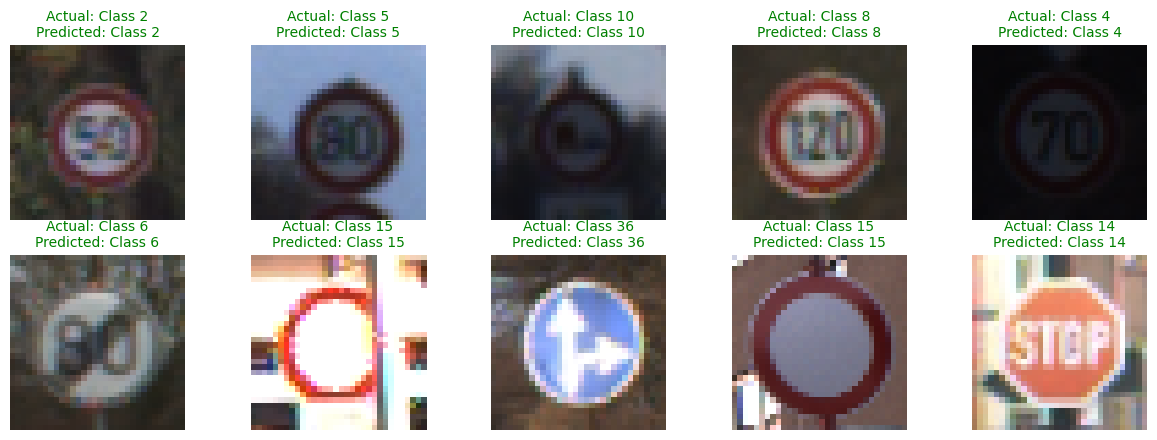

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Class labels (Modify this if your dataset has specific class names)
class_labels = {i: f"Class {i}" for i in range(len(np.unique(y_test)))}

# Get model predictions
y_pred_probs = model.predict(X_test_norm)  # Predict probabilities
y_pred = np.argmax(y_pred_probs, axis=1)   # Convert to class labels

# Number of images to display
num_images = 20
indices = np.random.choice(len(X_test_norm), num_images, replace=False)  # Randomly select images

# Plot images with actual & predicted labels
plt.figure(figsize=(15, 5))
for i, idx in enumerate(indices):
    plt.subplot(2, 5, i+1)
    plt.imshow(X_test[idx].squeeze(), cmap='gray')  # Display image
    actual_label = class_labels[y_test[idx]]
    predicted_label = class_labels[y_pred[idx]]

    # Set title with actual and predicted labels
    plt.title(f"Actual: {actual_label}\nPredicted: {predicted_label}", fontsize=10, color='green' if y_test[idx] == y_pred[idx] else 'red')
    plt.axis('off')

plt.tight_layout()
plt.show()


395/395 ━━━━━━━━━━━━━━━━━━━━ 33s 82ms/step


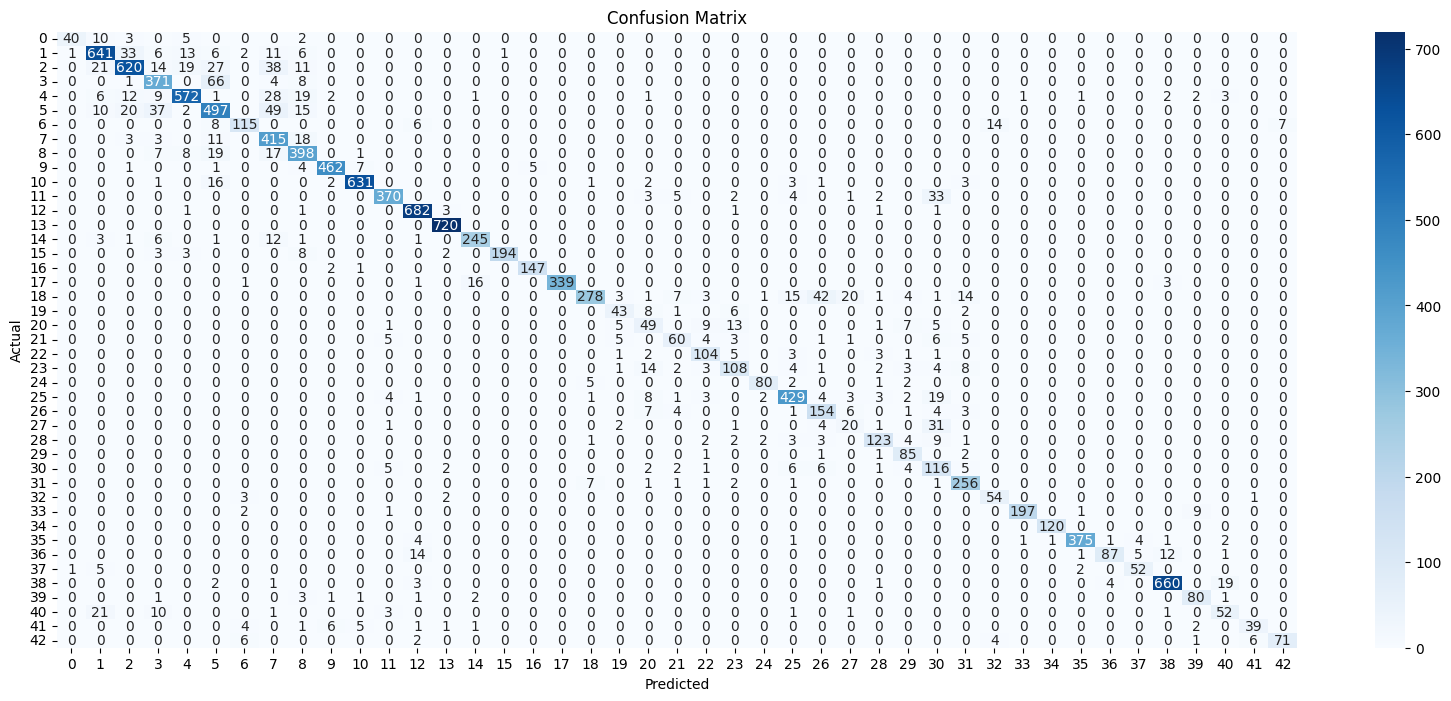

In [ ]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

y_pred_probs = model.predict(X_test_norm)
y_pred = np.argmax(y_pred_probs, axis=1)

conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(20, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


395/395 ━━━━━━━━━━━━━━━━━━━━ 34s 85ms/step


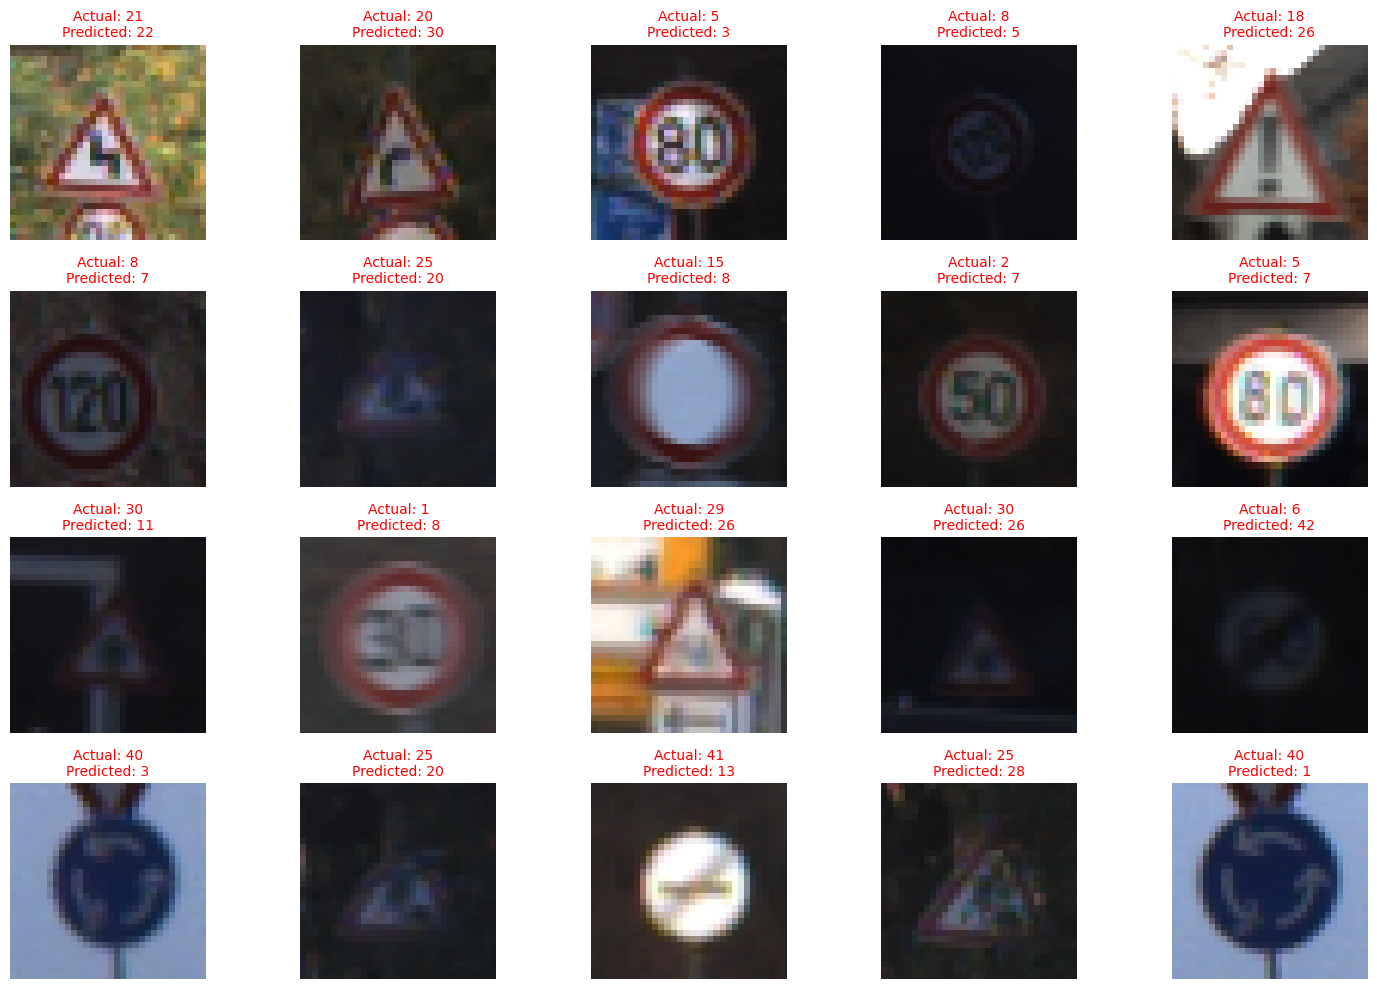

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Get model predictions
y_pred_probs = model.predict(X_test_norm)  # Predict probabilities
y_pred = np.argmax(y_pred_probs, axis=1)   # Convert to class labels

# Find misclassified indices
misclassified_idx = np.where(y_pred != y_test)[0]

# Number of misclassified images to display
num_images = min(20, len(misclassified_idx))  # Show up to 20 misclassified images

# Plot misclassified images with actual & predicted labels
plt.figure(figsize=(15, 10))
for i, idx in enumerate(misclassified_idx[:num_images]):
    plt.subplot(4, 5, i + 1)  # 4 rows, 5 columns
    plt.imshow(X_test[idx].squeeze(), cmap='gray')  # Display image
    actual_label = y_test[idx]
    predicted_label = y_pred[idx]

    # Title showing Actual vs Predicted
    plt.title(f"Actual: {actual_label}\nPredicted: {predicted_label}", fontsize=10, color='red')
    plt.axis('off')

plt.tight_layout()
plt.show()
